In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import os
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

def load_and_normalize_images(base_folder_path, class_labels):
    all_sequences = []
    all_labels = []

    for class_folder, label in class_labels.items():
        class_path = os.path.join(base_folder_path, class_folder)

        sequence_folders = [f for f in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, f))]

        for sequence_folder in sequence_folders:
            sequence_path = os.path.join(class_path, sequence_folder)

            file_names = os.listdir(sequence_path)
            sorted_files = sorted(file_names, key=lambda x: int(os.path.splitext(x)[0]))

            images = []

            for file_name in sorted_files:
                file_path = os.path.join(sequence_path, file_name)
                image = Image.open(file_path)
                image = ImageOps.grayscale(image)
                image_array = np.array(image) / 255.0  # Normalizar
                images.append(image_array)
            images = np.array(images) 
            all_sequences.append(images)
            all_labels.append(label)

    all_sequences = np.array(all_sequences)  
    all_labels = np.array(all_labels)  
    
    return all_sequences, all_labels

def display_sequences(sequences, num_sequences_to_show=5):
    for sequence in sequences[:num_sequences_to_show]:
        fig, axes = plt.subplots(1, len(sequence), figsize=(20, 20))
        for i, image in enumerate(sequence):
            if len(sequence) == 1:
                ax = axes
            else:
                ax = axes[i]
            ax.imshow(image)
            ax.axis('off')
        plt.show()

class_labels = {
    "neutral": 0,
    "frustration": 1
    
}



(712, 30, 224, 224)
(712,)


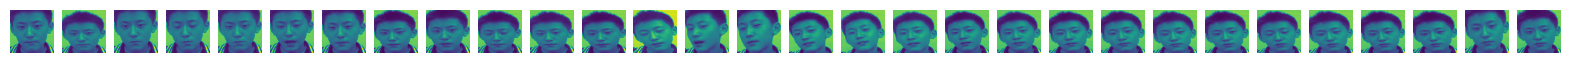

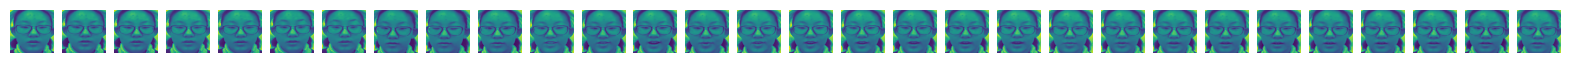

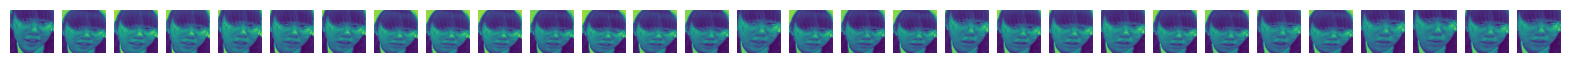

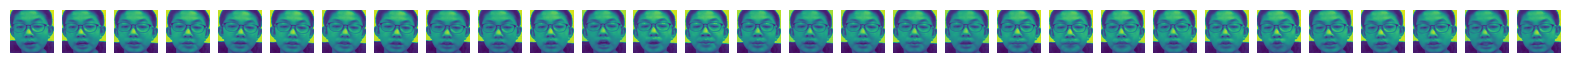

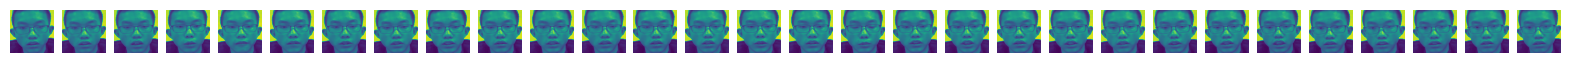

In [3]:
X_train, y_train = load_and_normalize_images('low_data/train'  , class_labels)
print(X_train.shape)
print(y_train.shape)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

display_sequences(X_train, num_sequences_to_show=5)


(133, 30, 224, 224)
(133,)


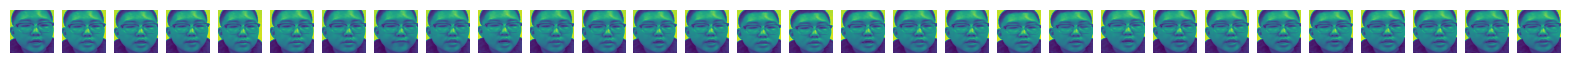

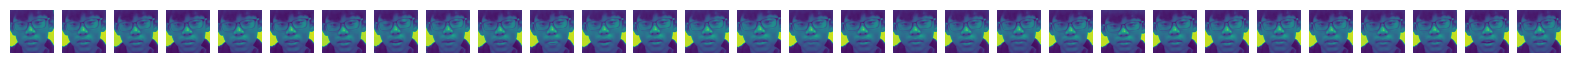

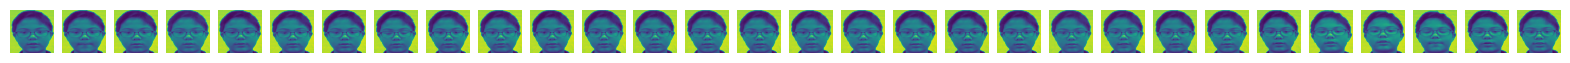

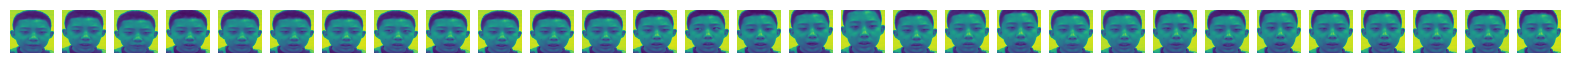

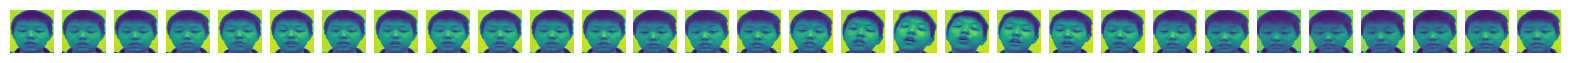

In [4]:
X_test, y_test = load_and_normalize_images('low_data/test' , class_labels)
X_test, y_test = shuffle(X_test, y_test, random_state=42)
print(X_test.shape)
print(y_test.shape)

display_sequences(X_test, num_sequences_to_show=5)

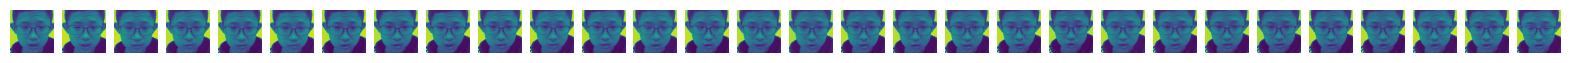

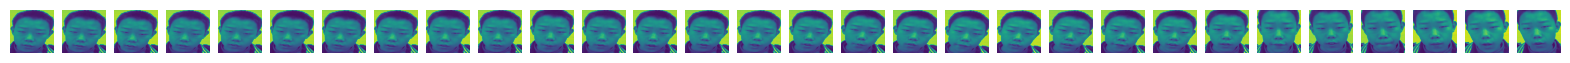

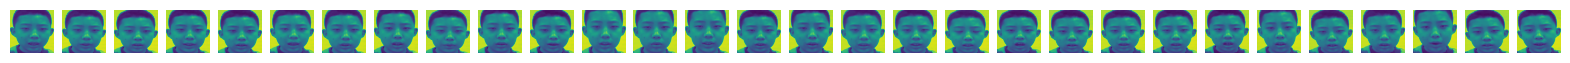

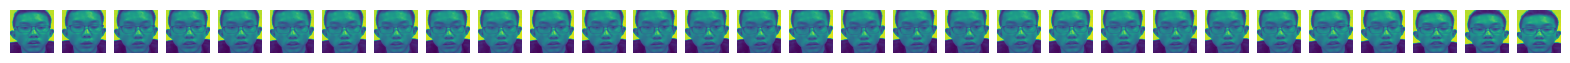

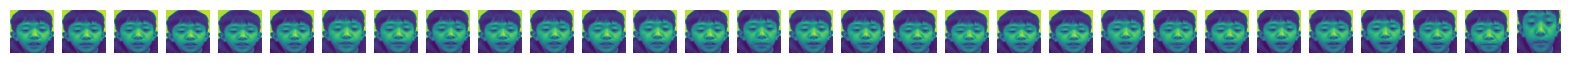

(133, 30, 224, 224)
(133,)


In [5]:
X_val, y_val = load_and_normalize_images('low_data/dev', class_labels)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

display_sequences(X_val, num_sequences_to_show=5)
print(X_val.shape)
print(y_val.shape)

In [6]:
height = 64
width = 64
channels = 3
sequence_length = 30

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed,Dropout,BatchNormalization,LSTM,Dense

model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=(30,224, 224, 1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.5))) 

model.add(TimeDistributed(Flatten()))

model.add(LSTM(50,return_sequences=False))
model.add(Dense(2,activation="softmax"))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 222, 222, 16)  160      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 111, 111, 16)  0        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 109, 109, 32)  4640     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 54, 54, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 52, 52, 32)   9

In [9]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [11]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val),callbacks=[early_stopping, reduce_lr])

Epoch 1/10
23/23 [==============================] - 257s 10s/step - loss: 0.6737 - accuracy: 0.6348 - val_loss: 0.8262 - val_accuracy: 0.1053 - lr: 0.0010
Epoch 2/10
23/23 [==============================] - 217s 9s/step - loss: 0.4570 - accuracy: 0.8034 - val_loss: 0.6883 - val_accuracy: 0.5865 - lr: 0.0010
Epoch 3/10
23/23 [==============================] - 215s 9s/step - loss: 0.3537 - accuracy: 0.8694 - val_loss: 0.6221 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 4/10
23/23 [==============================] - 215s 9s/step - loss: 0.2571 - accuracy: 0.9157 - val_loss: 0.5700 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 5/10
23/23 [==============================] - 213s 9s/step - loss: 0.1983 - accuracy: 0.9466 - val_loss: 0.6056 - val_accuracy: 0.6917 - lr: 0.0010
Epoch 6/10
23/23 [==============================] - 218s 9s/step - loss: 0.1597 - accuracy: 0.9565 - val_loss: 0.4668 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 7/10
23/23 [==============================] - 214s 9s/step - loss: 0.

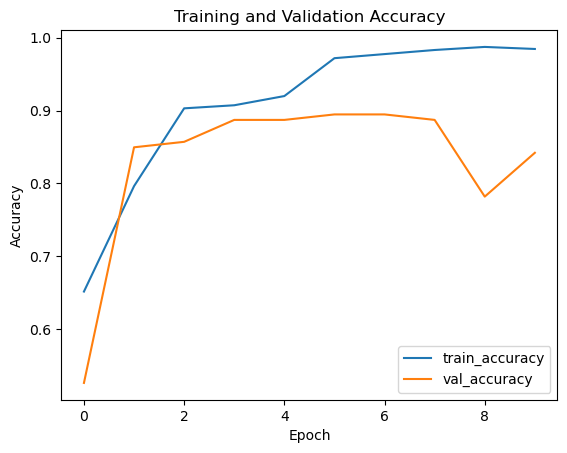

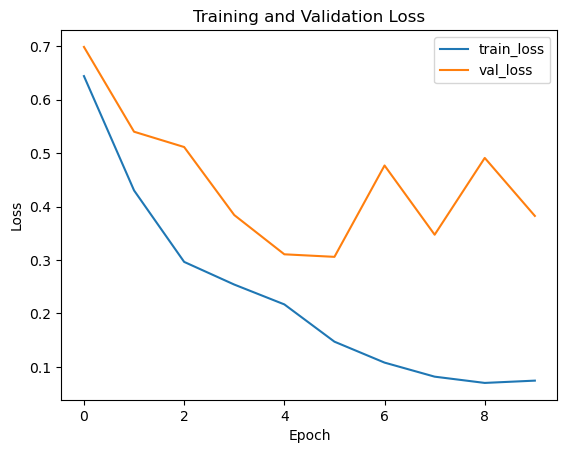

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

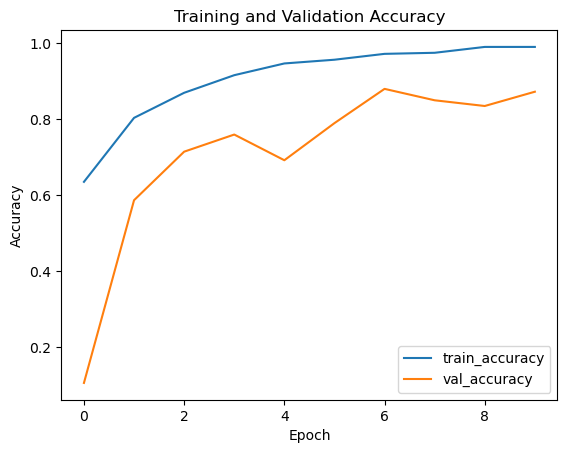

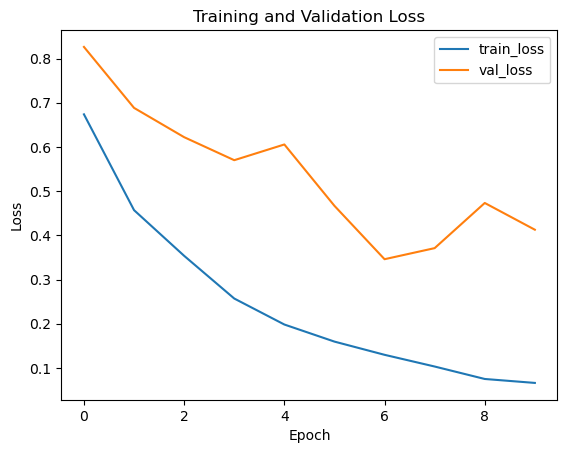

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
model.save('cnn-lstm-1.h5')

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')

5/5 [==============================] - 8s 1s/step - loss: 0.4118 - accuracy: 0.8722
Accuracy: 87.22%


In [17]:
from tensorflow.keras.utils import to_categorical

In [18]:
num_classes = len(np.unique(X_test))
test_labels = to_categorical(y_test, num_classes=num_classes)

In [19]:
predictions = model.predict(X_test)

print(predictions.shape) 


predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

5/5 [==============================] - 8s 1s/step
(133, 2)


In [20]:
from sklearn.metrics import recall_score, f1_score

recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Recall: 0.8721804511278195
F1 Score: 0.852703186537773


In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [25]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

     neutral       0.90      0.96      0.93       119
 frustration       0.29      0.14      0.19        14

    accuracy                           0.87       133
   macro avg       0.60      0.55      0.56       133
weighted avg       0.84      0.87      0.85       133



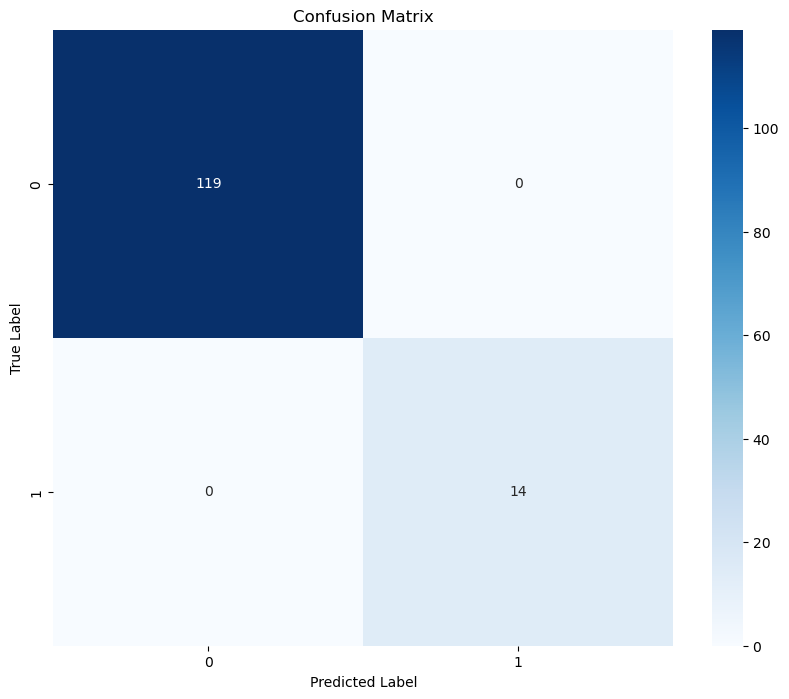

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, true_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()